# Python Version of GLMnet Model

**Goal:** Reproduce a Python version of the GLMnet model from "Forecasting restaurants with critical violations in Chicago" (Schenk Jr. et al, 2015).

**Result:** The parameters and results of this reproduced model appear to match the published version. This notebook saves a Scikit learn logistic regression model with the correct parameters in `glm-sklearn.pkl`.

## Load Cached RDS Files

In [1]:
import pandas as pd
import numpy as np
import pyreadr

In [2]:
raw_dat = pyreadr.read_r("../DATA/dat_model.Rds")[None]
raw_dat.head()

,Inspection_Date,License,Inspection_ID,Business_ID,criticalCount,seriousCount,minorCount,Facility_Type,pass_flag,fail_flag,...,caterers_liquor_license,mobile_food_license,heat_burglary,heat_garbage,heat_sanitation,Inspector_Assigned,precipIntensity,temperatureMax,windSpeed,humidity
0,15736,30790,269961.0,30790-20110416,0.0,0.0,2.0,Grocery_Store,1.0,0.0,...,0.0,0.0,26.992376,12.768572,37.748787,green,0.014587,53.496667,13.340000,0.900000
1,15265,1475890,507211.0,1475890-20110416,0.0,0.0,3.0,Restaurant,1.0,0.0,...,0.0,0.0,13.976557,12.895485,15.412267,blue,0.001907,59.046667,13.016667,0.550000
2,15265,1740130,507212.0,1740130-20110216,0.0,2.0,6.0,Restaurant,0.0,1.0,...,0.0,0.0,12.611239,8.004220,8.320330,blue,0.001907,59.046667,13.016667,0.550000
3,15266,1447363,507216.0,1447363-20110216,0.0,0.0,6.0,Restaurant,1.0,0.0,...,0.0,0.0,35.906383,26.238645,38.186618,blue,0.002737,56.153333,10.863333,0.616667
4,15267,1679459,507219.0,1679459-20100216,0.0,2.0,6.0,Restaurant,0.0,1.0,...,0.0,0.0,9.530785,3.401567,2.126788,blue,0.009987,52.730000,16.266667,0.690000


In [3]:
# Only keep "Retail Food Establishment"
dat_retail = raw_dat.query("LICENSE_DESCRIPTION == 'Retail Food Establishment'")

In [4]:
# Remove License Description
dat_all = dat_retail.drop(columns=["LICENSE_DESCRIPTION"])
dat = pd.DataFrame(dat_all.dropna())

In [5]:
# Add criticalFound variable to dat:
# dat["criticalFound"] = (dat["criticalCount"] > 0).astype(int)
# To be faithful to the R source:
dat["criticalFound"] = np.minimum(1, dat["criticalCount"])

In [6]:
# Set the key for dat
# setkey(dat, Inspection_ID)

## Create Model Data

In [7]:
xmat = pd.DataFrame()
xmat["Inspector"] = dat["Inspector_Assigned"]
xmat["pastSerious"] = np.minimum(dat["pastSerious"], 1)
xmat["pastCritical"] = np.minimum(dat["pastCritical"], 1)
xmat["timeSinceLast"] = dat["timeSinceLast"]
xmat["ageAtInspection"] = (dat["ageAtInspection"] > 4).astype(int)
xmat["consumption_on_premises_incidental_activity"] = dat["consumption_on_premises_incidental_activity"]
xmat["tobacco_retail_over_counter"] = dat["tobacco_retail_over_counter"]
xmat["temperatureMax"] = dat["temperatureMax"]
xmat["heat_burglary"] = np.minimum(dat["heat_burglary"], 70)
xmat["heat_sanitation"] = np.minimum(dat["heat_sanitation"], 70)
xmat["heat_garbage"] = np.minimum(dat["heat_garbage"], 50)
xmat["criticalFound"] = dat["criticalFound"]
xmat.head()

,Inspector,pastSerious,pastCritical,timeSinceLast,ageAtInspection,consumption_on_premises_incidental_activity,tobacco_retail_over_counter,temperatureMax,heat_burglary,heat_sanitation,heat_garbage,criticalFound
0,green,0.0,0.0,2.0,1,0.0,1.0,53.496667,26.992376,37.748787,12.768572,0.0
1,blue,0.0,0.0,2.0,1,0.0,0.0,59.046667,13.976557,15.412267,12.895485,0.0
2,blue,0.0,0.0,2.0,1,0.0,0.0,59.046667,12.611239,8.320330,8.004220,0.0
3,blue,0.0,0.0,2.0,1,0.0,0.0,56.153333,35.906383,38.186618,26.238645,0.0
4,blue,0.0,0.0,2.0,1,0.0,0.0,52.730000,9.530785,2.126788,3.401567,0.0


In [8]:
# Create model matrix
mm = pd.get_dummies(xmat)
inspectors = [
    "Inspector_blue",
    "Inspector_brown",
    "Inspector_green",
    "Inspector_orange",
    "Inspector_purple",
    "Inspector_yellow"
]
others = [
    "pastSerious",
    "pastCritical",
    "timeSinceLast",
    "ageAtInspection",
    "consumption_on_premises_incidental_activity",
    "tobacco_retail_over_counter",
    "temperatureMax",
    "heat_burglary",
    "heat_sanitation",
    "heat_garbage"
]
colnames = inspectors + others
mm.head()

,pastSerious,pastCritical,timeSinceLast,ageAtInspection,consumption_on_premises_incidental_activity,tobacco_retail_over_counter,temperatureMax,heat_burglary,heat_sanitation,heat_garbage,criticalFound,Inspector_blue,Inspector_brown,Inspector_green,Inspector_orange,Inspector_purple,Inspector_yellow
0,0.0,0.0,2.0,1,0.0,1.0,53.496667,26.992376,37.748787,12.768572,0.0,0,0,1,0,0,0
1,0.0,0.0,2.0,1,0.0,0.0,59.046667,13.976557,15.412267,12.895485,0.0,1,0,0,0,0,0
2,0.0,0.0,2.0,1,0.0,0.0,59.046667,12.611239,8.320330,8.004220,0.0,1,0,0,0,0,0
3,0.0,0.0,2.0,1,0.0,0.0,56.153333,35.906383,38.186618,26.238645,0.0,1,0,0,0,0,0
4,0.0,0.0,2.0,1,0.0,0.0,52.730000,9.530785,2.126788,3.401567,0.0,1,0,0,0,0,0


## Create Test/Train Partitions

In [9]:
# This integer value represents the split date: 2014-07-01
SPLIT_DATE = 16252

In [10]:
# Date range for entries before split date: "2011-09-02" to "2014-04-16"
# Date range for entries after split date: "2014-09-02" to "2014-10-31"
iiTrain = dat["Inspection_Date"] < SPLIT_DATE
iiTest = dat["Inspection_Date"] > SPLIT_DATE
# Check to see if any rows didn't make it through the model.matrix formula
len(dat), len(xmat), len(mm)

(18712, 18712, 18712)

## Generalized Linear Model (Logistic Regression)

In [11]:
import statsmodels.api as sm
from research.evaluation import evaluate_model, show_roc, show_prc
from research.strings import TARGET, PREDICTORS

In [12]:
# The lambda that minimizes error in cvfit is:
BEST_LAMBDA = 0.002970529

In [13]:
penalties = np.array([1 if "Inspector" in col else 0 for col in colnames])

In [14]:
predictors = colnames
X_train = mm[iiTrain][PREDICTORS].values
y_train = xmat[iiTrain][TARGET].values
X_test = mm[iiTest][PREDICTORS].values
y_test = xmat[iiTest][TARGET].values

In [15]:
from glmnet_python import cvglmnet, cvglmnetPredict, cvglmnetCoef

In [16]:
cvfit = cvglmnet(
    x=X_train.copy(), y=y_train.copy(),
    family="binomial", alpha=0, penalty_factor=penalties, ptype="deviance"
)

/anaconda/lib/python3.6/site-packages/numpy/lib/scimath.py:262: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)


In [17]:
print("The lambda that minimizes error in the R cvfit is: {0:.5f}".format(BEST_LAMBDA))
print("The lambda that minimizes error in this cvfit is: {0:.5f}".format(cvfit["lambda_min"][0]))

The lambda that minimizes error in the R cvfit is: 0.00297
The lambda that minimizes error in this cvfit is: 0.00271


In [18]:
betas = cvglmnetCoef(cvfit, s=np.array([BEST_LAMBDA]))
pd.DataFrame(betas, index=["Intercept"] + PREDICTORS)

,0
Intercept,-2.508383
Inspector_blue,0.944326
Inspector_brown,-1.287084
Inspector_green,-0.245173
Inspector_orange,0.198474
Inspector_purple,1.547364
Inspector_yellow,-0.693069
pastSerious,0.301503
pastCritical,0.427527
timeSinceLast,0.097143


In [19]:
y_pred_train = cvglmnetPredict(cvfit, newx=X_train, s=np.array([BEST_LAMBDA]), ptype="class").ravel()
y_pred_test = cvglmnetPredict(cvfit, newx=X_test, s=np.array([BEST_LAMBDA]), ptype="class").ravel()

In [20]:
evaluate_model(y_train, y_pred_train)

F1 Score = 0.02983
Precision = 0.46835
Recall = 0.01540


,Predicted +,Predicted -
Actual +,37,2365
Actual -,42,14631


In [21]:
evaluate_model(y_test, y_pred_test)

F1 Score = 0.07971
Precision = 0.61111
Recall = 0.04264


,Predicted +,Predicted -
Actual +,11,247
Actual -,7,1372


## Save Weights in Scikit Learn Model

In [22]:
from sklearn.linear_model import LogisticRegression
logres = LogisticRegression(solver="sag")
logres.fit(X_train, y_train)
logres.intercept_ = np.array([betas[0]])
logres.coef_ = np.array([betas[1:]])

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [23]:
evaluate_model(y_train, logres.predict(X_train))

F1 Score = 0.02983
Precision = 0.46835
Recall = 0.01540


,Predicted +,Predicted -
Actual +,37,2365
Actual -,42,14631


In [24]:
evaluate_model(y_test, logres.predict(X_test))

F1 Score = 0.07971
Precision = 0.61111
Recall = 0.04264


,Predicted +,Predicted -
Actual +,11,247
Actual -,7,1372


In [25]:
import pickle
model_filename = "models/sklearn-glm.pkl"
pickle.dump(logres, open(model_filename, "wb"))
print("Saved model to: {}".format(model_filename))

Saved model to: models/sklearn-glm.pkl


AUPRC = 0.317
Best F1 = 0.388 at threshold = 0.182


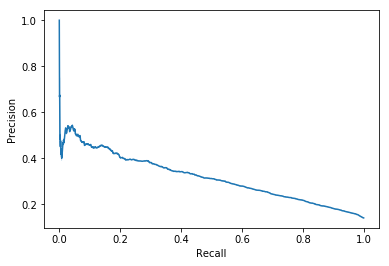

AUROC = 0.736


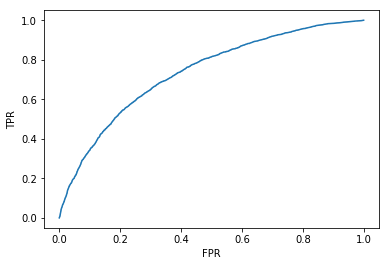

In [26]:
show_prc(logres, X_train, y_train)
show_roc(logres, X_train, y_train)

AUPRC = 0.317
Best F1 = 0.346 at threshold = 0.281


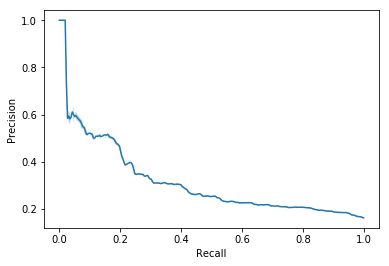

AUROC = 0.672


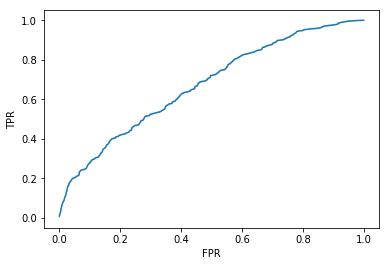

In [27]:
show_prc(logres, X_test, y_test)
show_roc(logres, X_test, y_test)

## Compare to Random Forest Classifier

F1 Score = 0.08638
Precision = 0.30233
Recall = 0.05039
AUPRC = 0.265
Best F1 = 0.356 at threshold = 0.258


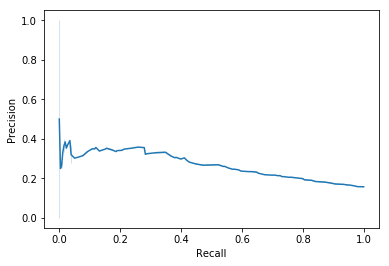

AUROC = 0.662


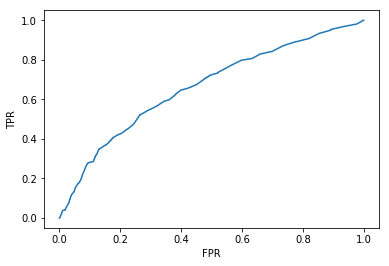

In [28]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier(n_estimators=100)
tree.fit(X_train, y_train)
evaluate_model(y_test, tree.predict(X_test))
show_prc(tree, X_test, y_test)
show_roc(tree, X_test, y_test)